## Introduction & Project Context ##
In finance, options are contracts that give the buyer the right, not the obligation, to buy or sell an underlying asset at a strike price on or before the expiration date. Among many, the two most common styles of option contracts are European and American. For European-style options, the contract can only be exercised at expiration, so the Black-Scholes PDE can be applied to find a closed-form solution for the price of the option. However, American-style options can be exercised anytime before expiration, which introduces an early exercise boundary. For this reason, no straightforward PDE can be solved to find a formula for the price of the option. 

There are several techniques for attempting to price American options, but for this project, I will be focusing on the widely used Monte-Carlo method called the **Longstaff-Schwartz algorithm**. As machine learning models become more advanced in their predictive power, I will be exploring how different ML models can be used to perform the regression within the LS algorithm for pricing American options.



## How the Longstaff-Schwartz algorithm works ##

The LS algorithm has several parameters regarding the initial behavior of the stock and conditions of the option contract:

- $S_0 = \text{Intial stock price}$
- $r = \text{Risk-Free interest rate}$
- $\sigma = \text{Volatility}$
- $T = \text{Time to expiration}$
- $K = \text{Strike price}$
- $n_{trials} = \text{number of simulated paths}$
- $n_{timesteps} = \text{number of timesteps per path}$

This algorithm uses Monte Carlo simulations to generate different potential paths that the underlying asset may go through. It leverages a backward recursive approach and regression to estimate the expected value of the option. The expected value is compared to the current exercise value to find the optimal payoff at each timestep. The average of all the simulated option prices is taken to determine the final price of the option.


In [102]:
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor

def longstaff_schwartz(S0, r, sigma, T, K, n_trials, n_timesteps, option_type, ml_model):
    """
    Core Longstaff-Schwartz implementation with ML models
    """
    # Monte-Carlo simulated paths
    S = np.zeros((n_trials, n_timesteps))
    S[:,0] = S0
    rng = np.random.default_rng(42)
    dW = rng.normal(0, 1, (n_trials, n_timesteps))
    dt = T / n_timesteps
    for t in range(1,n_timesteps):
        S_t = S[:,t-1] 
        S[:,t] = S_t + r*S_t*dt + sigma*S_t*dW[:,t-1] 

    
    ST = S[:,n_timesteps-1]
    payoffs = np.zeros((n_trials, n_timesteps))

    # Calculate terminal option prices
    if option_type == 'call':
        payoffs[:,n_timesteps-1] = np.maximum(ST - K, 0)
    elif option_type == 'put':
        payoffs[:,n_timesteps-1] = np.maximum(K - ST, 0)

    # Use backward induction to find final option price 
    for t in range(n_timesteps-2,-1,-1):
        # Determine which paths are in-the-money and out-of-the-money
        if option_type == 'call':
            itm_indices = np.where(S[:,t] > K)
            otm_indices = np.where(S[:,t] <= K)
        elif option_type == 'put':
            itm_indices = np.where(S[:,t] < K)
            otm_indices = np.where(S[:,t] >= K)
        # If no paths are in-the-money, do not exercise any option
        if len(itm_indices[0]) == 0:
            payoffs[:, t] = payoffs[:, t+1] * np.exp(-r*dt)
            continue
        X = S[itm_indices, t].reshape(-1, 1) # Current stock prices for in-the-money paths
        y = payoffs[itm_indices,t+1] * np.exp(-r*dt) # Discounted expected values of the option at the next timestep
        # Choose ML model
        match ml_model:
            case 'poly':
                model = make_pipeline(
                    PolynomialFeatures(degree=3),
                    LinearRegression(fit_intercept=False)
                )
                model.fit(X, y.ravel())
            case 'random forest':
                model = RandomForestRegressor()
                model.fit(X, y.ravel())
            case 'xgboost':
                model = xgb.XGBRegressor()
                model.fit(X, y)
            case 'mlp':
                model = MLPRegressor()
                model.fit(X, y.ravel())
            case _:
                raise ValueError(f"Unknown model type: {ml_model}")
            
        future_val = model.predict(X).flatten() # Predicted discounted expected value
        # Calculate current exercise price
        if option_type == 'call':
            current_val = np.maximum(S[itm_indices, t] - K, 0).flatten()
        elif option_type == 'put':
            current_val = np.maximum(K - S[itm_indices, t], 0).flatten()

        itm = itm_indices[0]  
        # Determines optimal time to exercise the option
        should_exercise = current_val > future_val
        # Sets payoffs accordingly
        payoffs[itm[should_exercise], t] = current_val[should_exercise]
        payoffs[itm[~should_exercise], t] = payoffs[itm[~should_exercise], t+1] * np.exp(-r*dt)
        payoffs[otm_indices, t] = payoffs[otm_indices, t+1] * np.exp(-r*dt)


    price = np.mean(payoffs[:,0]) # average of all option prices

    # 95% confidence interval
    SE = np.std(payoffs[:,0], ddof=1) / np.sqrt(n_trials)
    lower = price-1.96*SE
    upper = price+1.96*SE

    return price, lower, upper

## Choice of Models ##

In this project, I carefully chose four different machine learning approaches for the regression component within the Longstaff-Schwartz algorithm. For all models, the inputs are the stock prices for in-the-money paths only and the targets are discounted expected values of the option at the next timestep:

- **Polynomial Regression**
  - **Reason I chose this model:** This is the traditional baseline model that is typically implemented in the LS algorithm. It is computationally efficient, and should perform well in capturing the exercise boundary if it can be described by a polynomial.
  - **How it fits in the LS Algorithm:** At every timestep, the model tries to fit a polynomial of degree n for a function to find expected values of the option based on the current stock price. Predictions from this model come from the determined polynomial.
  
- **Random Forest**
  - **Reason I chose this model:** A random forest model could do a better job in this handling potential discontinuities that polynomial regression would not be able to handle. It can capture non-linear exercise boundaries without assuming an overall functional form.
  - **How it fits in the LS Algorithm:** At every timestep, the model creates several decision trees to categorize the expected value of the option based on the current stock price. It then averages the results from these trees for the final prediction.

- **XGBoost**
  - **Reason I chose this model:** This model could potentially be more efficient and robust than random forest. While both are ensemble algorithms, the sequential boosting in XGBoost could capture a lot more details that could be missed from the parallel bagging in random forest. Also, regularization will help model to avoid overfitting.
  - **How it fits in the LS Algorithm:** At every timestep, the model uses gradient boosting to sequentially add weak learners, each correcting previous errors to create a final robust learner. This final learner will be able to predict expected values of the option based on the current stock price. 

- **Multi-Layer Perceptron (MLP)**
  - **Reason I chose this model:** This model could theoretically outperform all other models given the correct hyperparameter tuning and regularization. Neural networks work well with large amounts of data, so using it in an algorithm that also uses Monte Carlo Simulation could have promising results.
  - **How it fits in the LS Algorithm:** At every timestep, layers of neurons are created, implicitly discovering its own relevant features and finding more nuanced patterns in the data. Then, using backpropagation, the MLP assigns weights to each neuron to create a universal function approximator capable of learning complex stock price to continuation value mappings.

For my benchmark, all ML-enhanced Longstaff-Schwartz results are compared against the **Binomial Tree model**, a widely accepted lattice-based pricing method that provides reliable American option valuations. This method starts at a root node with the value of $S_0$. A binary tree is created, branching into possible upward and downward paths at each step. Then, using backward induction, the option value at each node is calculated as the maximum of the immediate exercise value or the discounted expected future value based on risk-neutral probabilities.


In [103]:
def binomial_tree(S0, r, sigma, T, K, n_timesteps, option_type):
    """
    Binomial Tree implementation for benchmark
    """
    stock_prices = [[S0]]
    dt = T / n_timesteps
    u = np.exp(sigma*np.sqrt(dt)) # upward branch multiplier
    d = 1/u # downward branch multiplier
    p = (np.exp(r*dt) - d) / (u - d) # probability of stock following the up branch 

    # Constructs tree by adding additionally factors of u and d to previous timestep
    for t in range(1,n_timesteps):
        new_prices = [ele*d for ele in stock_prices[-1]] + [S0 * (u**t)]
        stock_prices.append(new_prices)

    # Calculate terminal option prices
    if option_type == 'call':
        option_prices = [max(ele - K, 0) for ele in stock_prices[-1]]
    elif option_type == 'put':
        option_prices = [max(K - ele, 0) for ele in stock_prices[-1]]

    # Use backward induction to find final option price 
    for t in range(n_timesteps-2,-1,-1):
        # Consider current timestep and next timestep
        current_prices = [0]*(t+1)
        future_prices = option_prices
        for i in range(t+1):
            # Calculate current exercise price
            if option_type == 'call':
                exercise_val = max(stock_prices[t][i] - K, 0)
            elif option_type == 'put':
                exercise_val = max(K - stock_prices[t][i], 0)
            # Calculate discounted expected value through predetermined probabilities
            expected_val = ((p * future_prices[i+1]) + ((1-p) * future_prices[i])) * np.exp(-r*dt) 
            current_prices[i] = max(exercise_val,expected_val); # Determine optimal price for option
        option_prices = current_prices


    return option_prices[0]

*Side Note: The typical implementation of this method involves constructing a binary tree with depth $n_{timesteps}$, which results in a time and space complexity of $O(2^n)$. My implementation uses a list, and each element in the list is every possible stock value at the timestep. This yields a time and space complexity of $O(n^2)$, which makes the method much more efficient for large $n_{timesteps}$.*

## Testing Framework ##

In order to capture all patterns for how the models perform under varying data, I systematically chose different market conditions for a call option with $S_0 = 100$:

- $T_{test} = [0.25, 0.5, 1]$
    - To reflect option contracts with short, medium, and long maturities
- ${\sigma}_{test} = [0.15, 0.25, 0.4]$
    - To reflect underlying assests with low, medium, and high volatilities
- $K_{test} = [90, 100, 110]$
    - To reflect options that are out-of-the-money, at-the-money, and in-the-money
- $r_{test} = [0.01,0.03,0.05]$
    - To reflect market conditions with low, medium, and high risk-free rates

In [104]:
S0 = 100
n_trials = 100
n_timesteps = 100
option_type = 'call'

test_T = [0.25, 0.5, 1]
test_sigma = [0.15, 0.25, 0.4]
test_K = [90, 100, 110]
test_r = [0.01, 0.03, 0.05]
test_models = ['poly', 'random forest', 'xgboost', 'mlp']

Before collecting data, I created a new function to store the pricing results from all the models in a organized dicionary. 

In [105]:
def compare_models(S0, r, sigma, T, K, n_trials, n_timesteps, option_type):
    models = ['poly', 'random forest', 'xgboost', 'mlp']
    results = {}
    for model in models:
        price, lower, upper = longstaff_schwartz(S0, r, sigma, T, K, n_trials, n_timesteps, option_type, model)
        results[model] = (price, lower, upper)
    return results

I stored all the results into a pandas DataFrame, including absolute and relative error from the LS algorithm compared to the binomial tree model. *Uncomment the loop to run the models. Otherwise, read the DataFrame from the existing option_prices.csv file*

In [106]:
from itertools import product
import pandas as pd

'''
option_prices = pd.DataFrame(
    columns=['T', 'sigma', 'K', 'r', 'model', 'Model Price', 'Binomial Price', 'Lower', 'Upper', 'Absolute Error', 'Relative Error']
)

# Add standard market conditions
for T, sigma, K, r in (list(product(test_T, test_sigma, test_K, test_r))):
    results = compare_models(S0, r, sigma, T, K, n_trials, n_timesteps, option_type)
    binomial_price = binomial_tree(S0, r, sigma, T, K, n_timesteps, option_type)
    for model in test_models:
        print(T, sigma, K, r, model)
        model_price, lower, upper = results[model]
        abs_error = abs(model_price-binomial_price)
        rel_error = (model_price-binomial_price) / binomial_price * 100
        option_prices.loc[len(option_prices)] = [T, sigma, K, r, model, model_price, binomial_price, lower, upper, abs_error, rel_error]




option_prices.to_csv('option_prices.csv')
'''

option_prices = pd.read_csv('option_prices.csv')

## Initial Results ##

After gathering the data, I used Root Mean Squared Error (RMSE) and Mean Absolute Percentage Error (MAPE), 2 different metrics to evalute the accuracy of these predictive models compare dot the binomial tree model. Run the following code cell to see the bar charts plots on these values for each model.

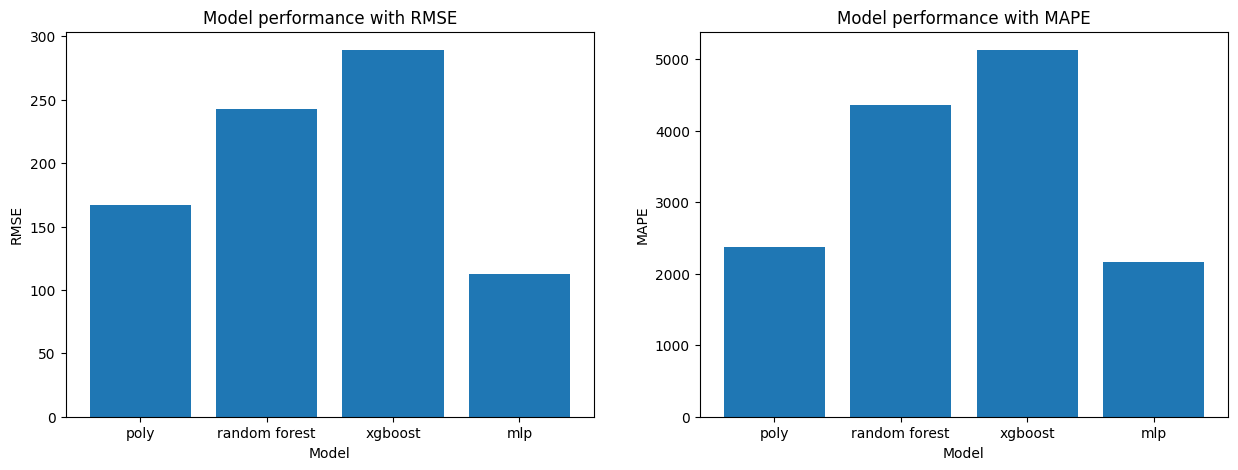

In [107]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

RMSE = lambda data: np.sqrt(sum(([d*d for d in data])) / len(data))
MAPE = lambda data: (sum([abs(d) for d in data])) / len(data)

RMSEs = {}
MAPEs = {}
for model in test_models:
    model_data = option_prices[option_prices['model'] == model]
    
    abs_error_data = model_data['Absolute Error']
    rel_error_data = model_data['Relative Error']


    RMSEs[model] = RMSE(abs_error_data)
    MAPEs[model] = MAPE(rel_error_data)

axes[0].bar(RMSEs.keys(), RMSEs.values())
axes[0].set_xlabel('Model')
axes[0].set_ylabel('RMSE')
axes[0].set_title('Model performance with RMSE')

axes[1].bar(MAPEs.keys(), MAPEs.values())
axes[1].set_xlabel('Model')
axes[1].set_ylabel('MAPE')
axes[1].set_title('Model performance with MAPE')
    

plt.show()

From these charts, I see very similar patterns. It seems that before and hyperparameter tuning or feature engineering, MLP is in the most accurate, followed by the original polynomial regression, followed by random forest, and then surprisingly, XGBoost is in last.

But a simple bar chart can't show all the important information the data has to offer. I used RMSE to evaluate the accuracy of these models compared to the binomial tree method. Run the following code cell to see the plots on the performance of each model under different conditions.

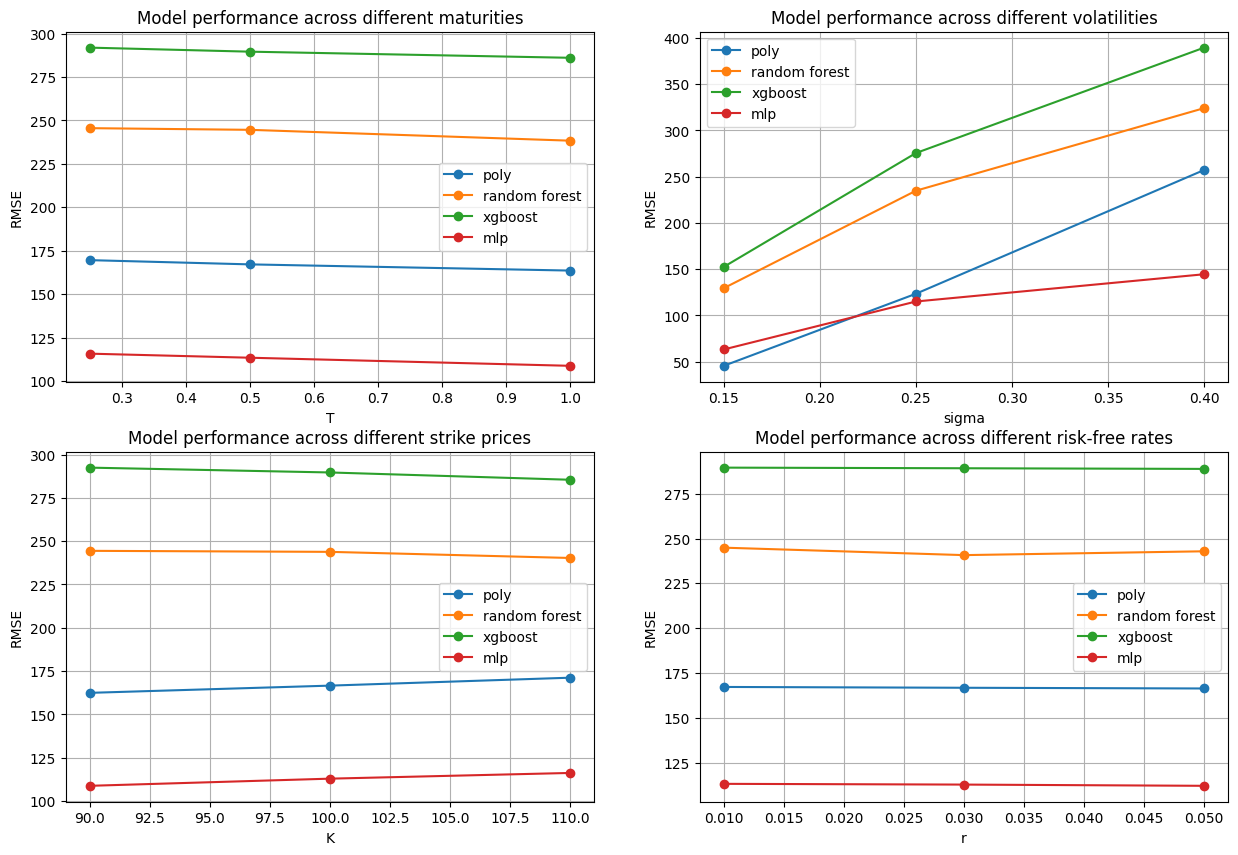

In [108]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

parameters = [test_T, test_sigma, test_K, test_r]
param_names = {'T': "maturities", 'sigma': "volatilities", 'K': "strike prices", 'r': "risk-free rates"}
i = 0

for metric, met_name in zip(parameters, param_names.keys()):
    for model in test_models:
        model_data = option_prices[option_prices['model'] == model]
        x = metric[:]
        abs_error_data = []
        for m in metric:
            insert = model_data[model_data[met_name] == m]['Absolute Error']
            abs_error_data.append(insert)
        y = [RMSE(data) for data in abs_error_data]
        axes[i].plot(x, y, label=model, marker='o') 
    axes[i].set_xlabel(met_name)
    axes[i].set_ylabel('RMSE')
    axes[i].set_title('Model performance across different ' + param_names[met_name])
    axes[i].legend() 
    axes[i].grid(True)  
    i+=1
    
plt.show()

It seems that for each model, there was no significant difference in accuracy when pricing options of different maturity, strike price, or risk-free interest rate. However, we can see that as volatility grew, every model grew increasingly innaccurate.